In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss
from sklearn.metrics import matthews_corrcoef

In [2]:
data = pd.read_csv("dat_15-09-2022_morgan_chiral_2048FP.csv")

In [3]:
df = pd.DataFrame(data)
df.reset_index(drop=True, inplace=True)
df

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP2040,FP2041,FP2042,FP2043,FP2044,FP2045,FP2046,FP2047,FP2048,Target
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
y= df.Target
X=df.drop('Target', axis=1)

In [5]:
cat_features=list(range(0,X.shape[1]))
#print(cat_features)

In [6]:
df.Target.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [7]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

In [8]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [9]:
y_train.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [10]:
#Read the validation set
v_test_data = pd.read_csv("val_15-09-2022_morgan_chiral_2048FP.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(367, 2049)

In [11]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [12]:
# Normalize
#X_v_test_data = (X_v_test_data - np.min(X_v_test_data)) / (np.max(X_v_test_data) - np.min(X_v_test_data)).values
#X_v_test_data.shape

In [12]:
#Grid_search_obtained_parameters
#rf = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=20, max_features='log2', min_samples_leaf=3, min_samples_split=10, n_estimators=200,n_jobs=-1)
#My hyperparameters for 1024 and 2048 ds
rf = RandomForestClassifier(n_estimators=3000,min_samples_leaf=5,max_depth=7,min_samples_split=10,criterion='gini',max_features="auto",n_jobs=-1)
#Manual parameters from gridsearchcv for 1024ds
#rf = RandomForestClassifier(bootstrap= 'True', ccp_alpha= 0.0, criterion= 'entropy', max_depth= 15, max_features= 1.0, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators= 1000, n_jobs= -1, oob_score= 'False', verbose= 0, warm_start= 'False')
rf.fit(x_train.T,y_train.T)
v_predictions = rf.predict(X_v_test_data)
acc_train=rf.score(x_train.T,y_train.T)*100
v_acc_test = rf.score(X_v_test_data, Y_v_test_data)*100
print(acc_train)
print(v_acc_test)

74.44595205789236
68.11989100817438


In [13]:
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
#mcc = matthews_corrcoef(Y_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
#r_auc_score = roc_auc_score(Y_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
#bloss = brier_score_loss(Y_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
#kappa = cohen_kappa_score(Y_test_data, v_predictions)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:68.120
Sensitivity:0.597
Specificity:0.722
Balance accuracy:0.659
MCC: 0.307
AUC: 0.659
Brier_loss: 0.319
False Postive rate: 0.278
False Negative rate: 0.403
Precision: 0.507
Recall: 0.597
F1: 0.548
Kappa: 0.304


In [14]:
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.79      0.72      0.75       248
           1       0.51      0.60      0.55       119

    accuracy                           0.68       367
   macro avg       0.65      0.66      0.65       367
weighted avg       0.70      0.68      0.69       367



<AxesSubplot:xlabel='Predicted Value', ylabel='True Value'>

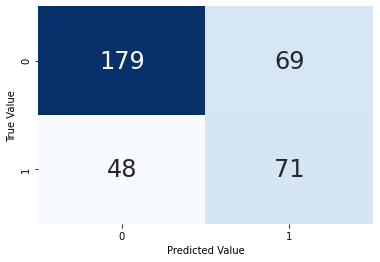

In [15]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [16]:
r_probs = [0 for _ in range(len(Y_v_test_data))]
cb_prob = rf.predict_proba(X_v_test_data)
cb_prob = cb_prob[:,1]

In [18]:
prediction_val=rf.predict(X_v_test_data)

In [19]:
prediction_val=pd.DataFrame(prediction_val)

In [20]:
prediction_val.to_csv("RF_2048_Valitation_Prediction.csv")

In [21]:
cb_prob

array([0.48032841, 0.45418368, 0.18581011, 0.57357486, 0.47392919,
       0.49110302, 0.57022689, 0.54487181, 0.53418117, 0.60454338,
       0.49541867, 0.56672142, 0.47983433, 0.51152585, 0.50005533,
       0.41264802, 0.43229276, 0.45968253, 0.51023447, 0.591643  ,
       0.42584857, 0.5770016 , 0.37599754, 0.55864345, 0.44182244,
       0.54947715, 0.45037951, 0.54978951, 0.59031707, 0.36108097,
       0.44854168, 0.40473261, 0.54770166, 0.53562749, 0.52851472,
       0.4298188 , 0.53210657, 0.45522429, 0.4847314 , 0.35790451,
       0.45796364, 0.59009366, 0.31483661, 0.34012453, 0.54409054,
       0.42397266, 0.40043682, 0.42550437, 0.39075857, 0.55706395,
       0.44777899, 0.36650991, 0.48764137, 0.53483294, 0.48912719,
       0.4020924 , 0.52478993, 0.4416932 , 0.44940719, 0.44712135,
       0.46667897, 0.60937299, 0.4167922 , 0.42890078, 0.40230985,
       0.54867761, 0.45249618, 0.34890404, 0.3972414 , 0.29035872,
       0.51409981, 0.40408461, 0.59722911, 0.52306528, 0.53257

In [22]:
r_auc_score = roc_auc_score(Y_v_test_data, cb_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, cb_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.695005421523448


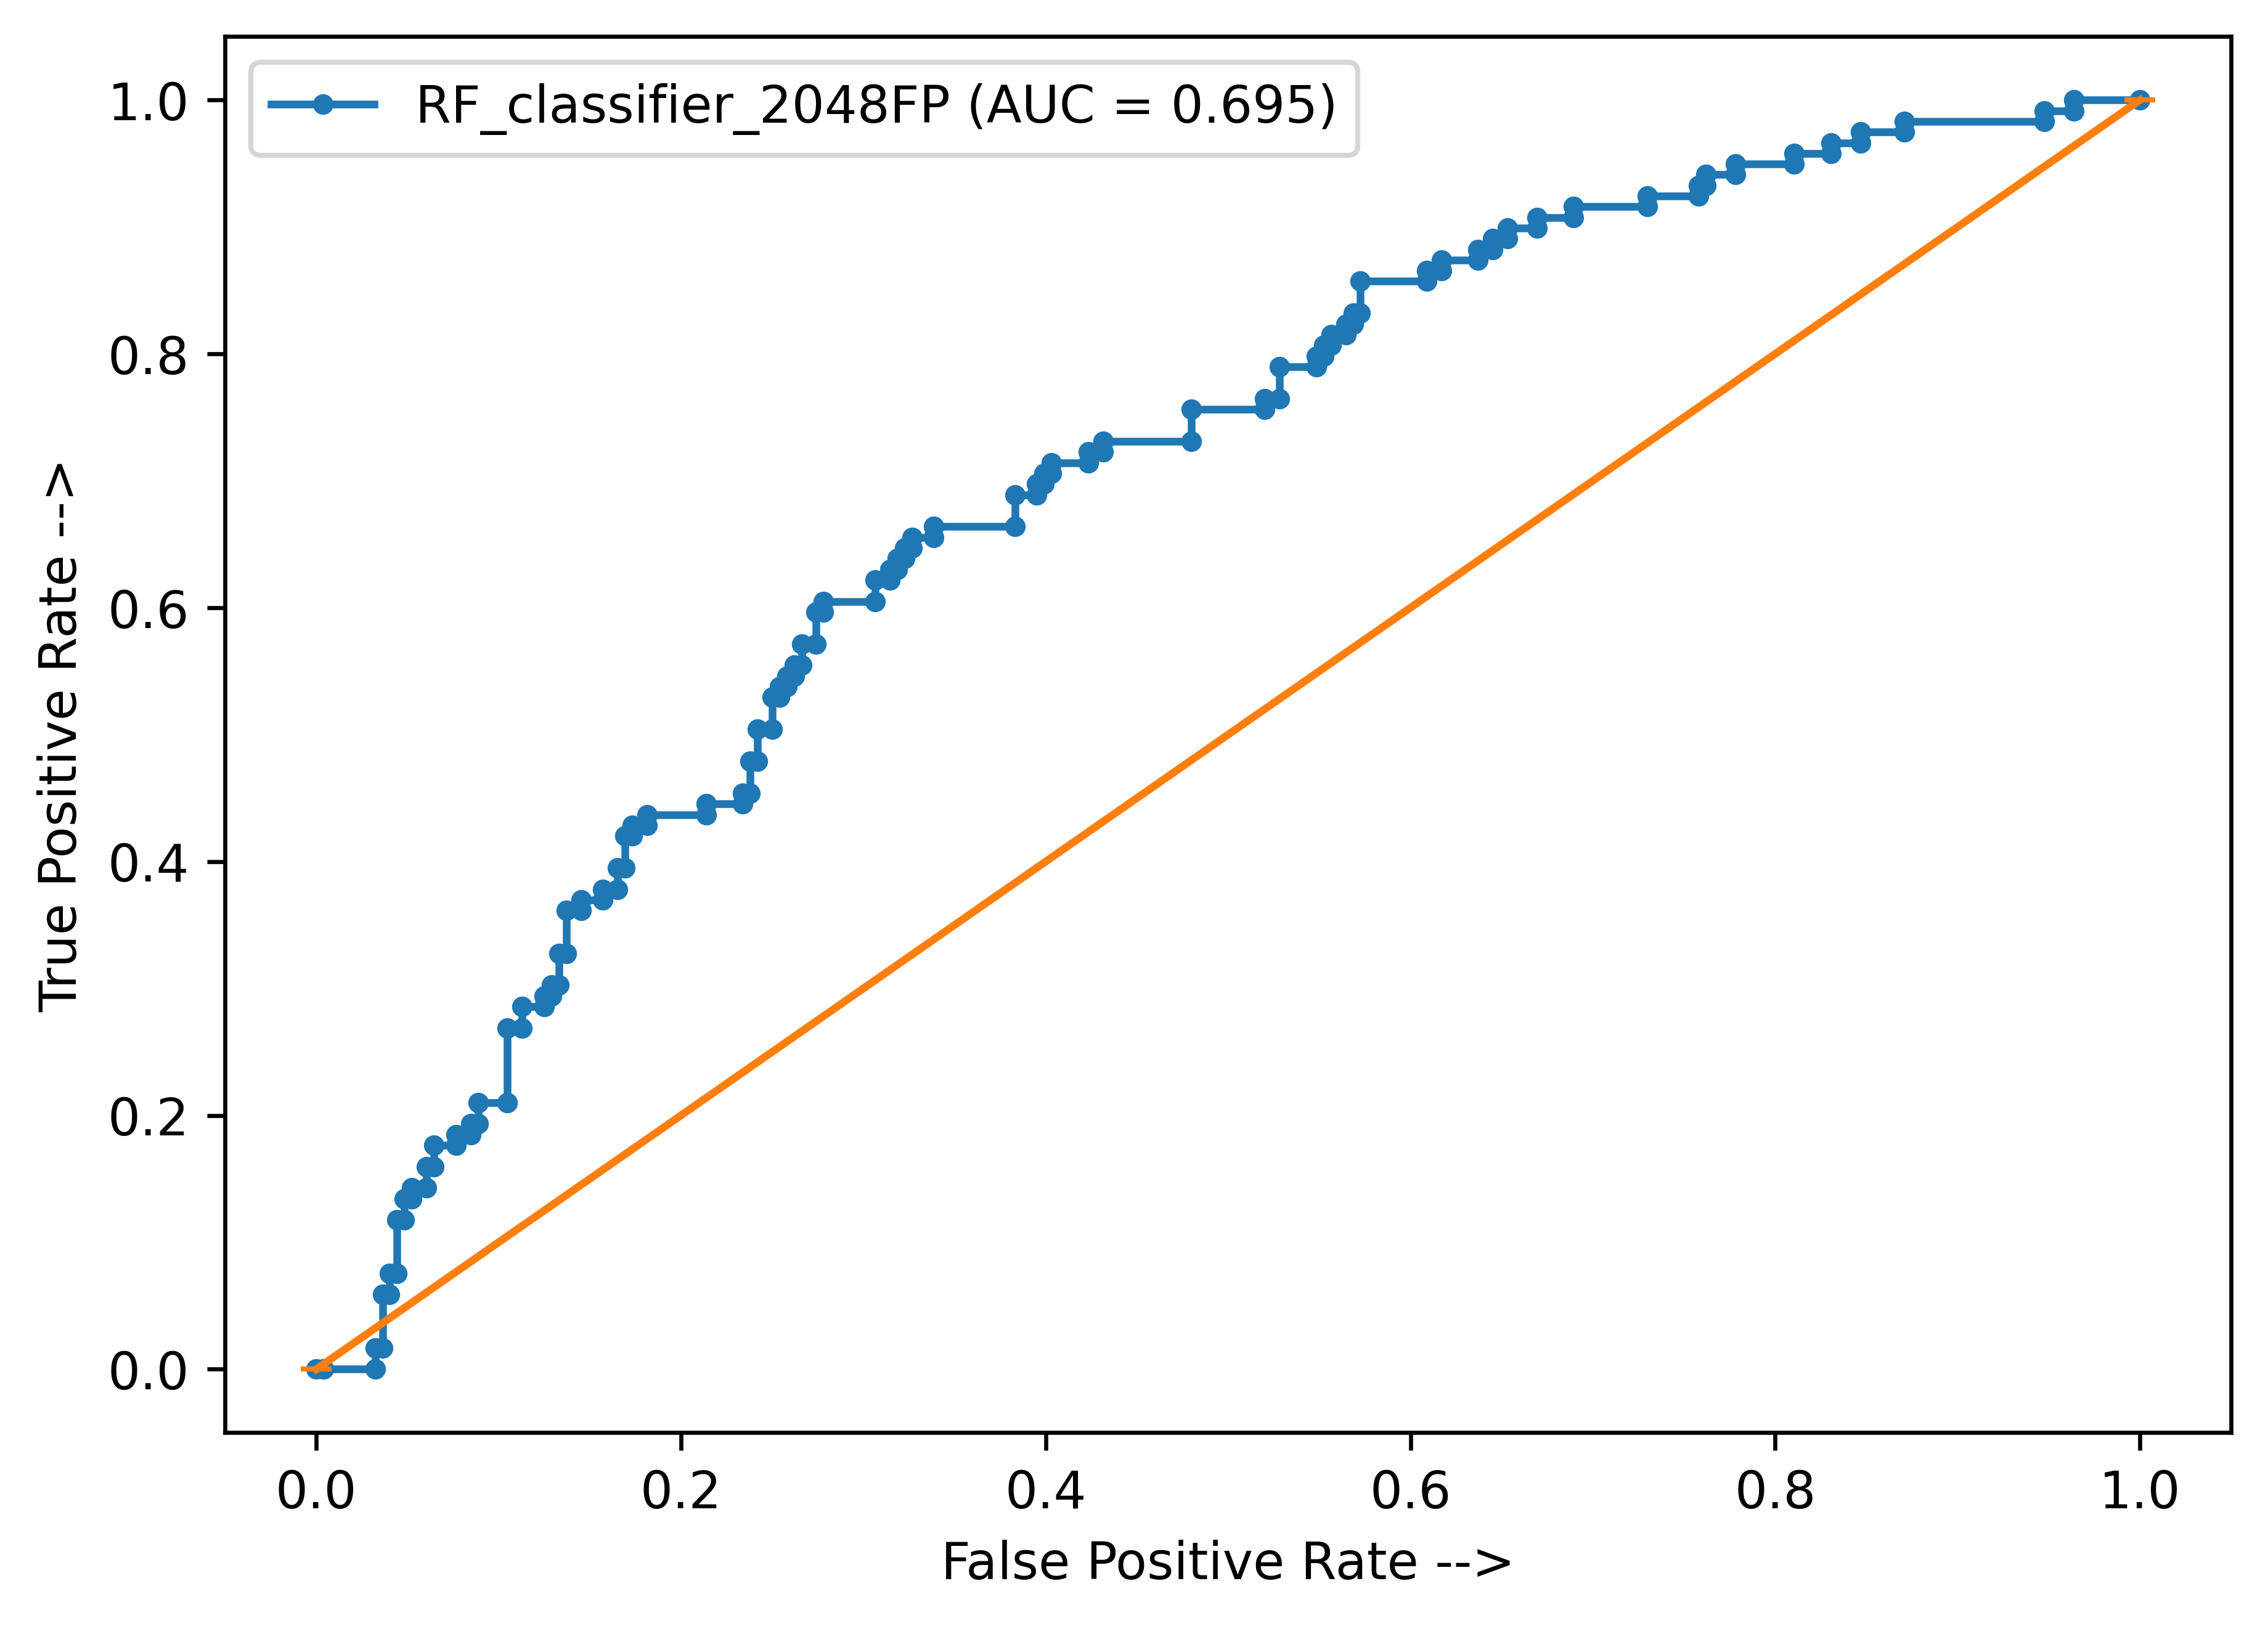

In [24]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='RF_classifier_2048FP (AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()
#plt.savefig('RF_AUC.png', dpi=600, bbox_inches='tight')

In [26]:
#Read external set
external_data = pd.read_csv("cyclic_ind_16-09-2022_morgan_chiral_2048FP.csv")
data_for_screening = pd.DataFrame(external_data)
data_for_screening

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP2039,FP2040,FP2041,FP2042,FP2043,FP2044,FP2045,FP2046,FP2047,FP2048
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11142,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
11143,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
11144,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
#test external data
test_prob = rf.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('RF_2048FP_External_probability.csv')

In [33]:
prediction_ext=rf.predict(data_for_screening)
prediction_ext=pd.DataFrame(prediction_ext)
prediction_ext.to_csv("RF_2048_External_Prediction.csv")

In [ ]:
##Plotting the mean AUC

In [28]:
from sklearn.metrics import RocCurveDisplay

In [29]:
from scipy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-30-42107118d433>:13: DeprecationWarning: scipy.interp i

<Figure size 4200x3000 with 0 Axes>

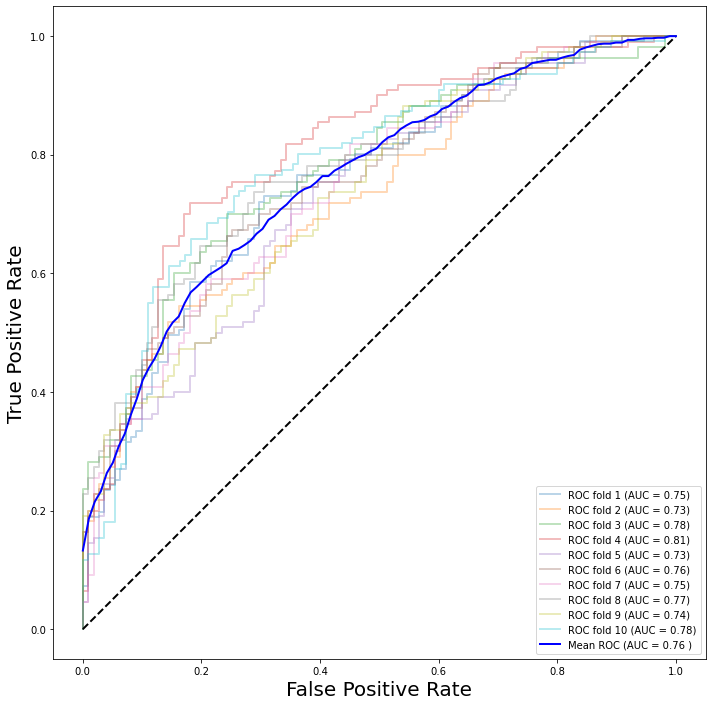

In [30]:
# plot k fold ROC
plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = rf.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.show()

In [ ]:
## Y Randomization

In [31]:
accuracy_list = []
for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    rf.fit(x_train, y_train)
    scrmb_predictions = rf.predict(X_v_test_data)
    print(i)
    accuracy = roc_auc_score(Y_v_test_data, scrmb_predictions)
    accuracy_list.append(accuracy)
print
accuracy_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[0.5394076985632963,
 0.5751897533206831,
 0.6175454052588778,
 0.46226958525345624,
 0.4313330170777989,
 0.4439380590946056,
 0.5116732176741665,
 0.5367138791000271,
 0.5867952019517485,
 0.459575765790187,
 0.42899498509081047,
 0.5111649498509081,
 0.42277717538628357,
 0.42093046896177827,
 0.5404072919490377,
 0.5891332339387367,
 0.49435822716183253,
 0.5054554079696394,
 0.4504947140146381,
 0.46579357549471395,
 0.5640925725128761,
 0.5508267823258335,
 0.4414306044998645,
 0.4313499593385741,
 0.5533511791813499,
 0.4587286527514231,
 0.6353517213336948,
 0.5224146110056925,
 0.5331898888587693,
 0.4970520466251016,
 0.4120188397939822,
 0.527802249932231,
 0.4720113851992409,
 0.6067870696665764,
 0.49554418541610196,
 0.48309162374627274,
 0.5923353212252644,
 0.5269720791542423,
 0.5061330984006506,
 0.46445513689346707,
 0.4220994849552725,
 0.3965674979669287,
 0.5368833017077799,
 0.5358667660612633,
 0.5109955272431554,
 0.5301572241799946,
 0.38430130116562755,
 0.42

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

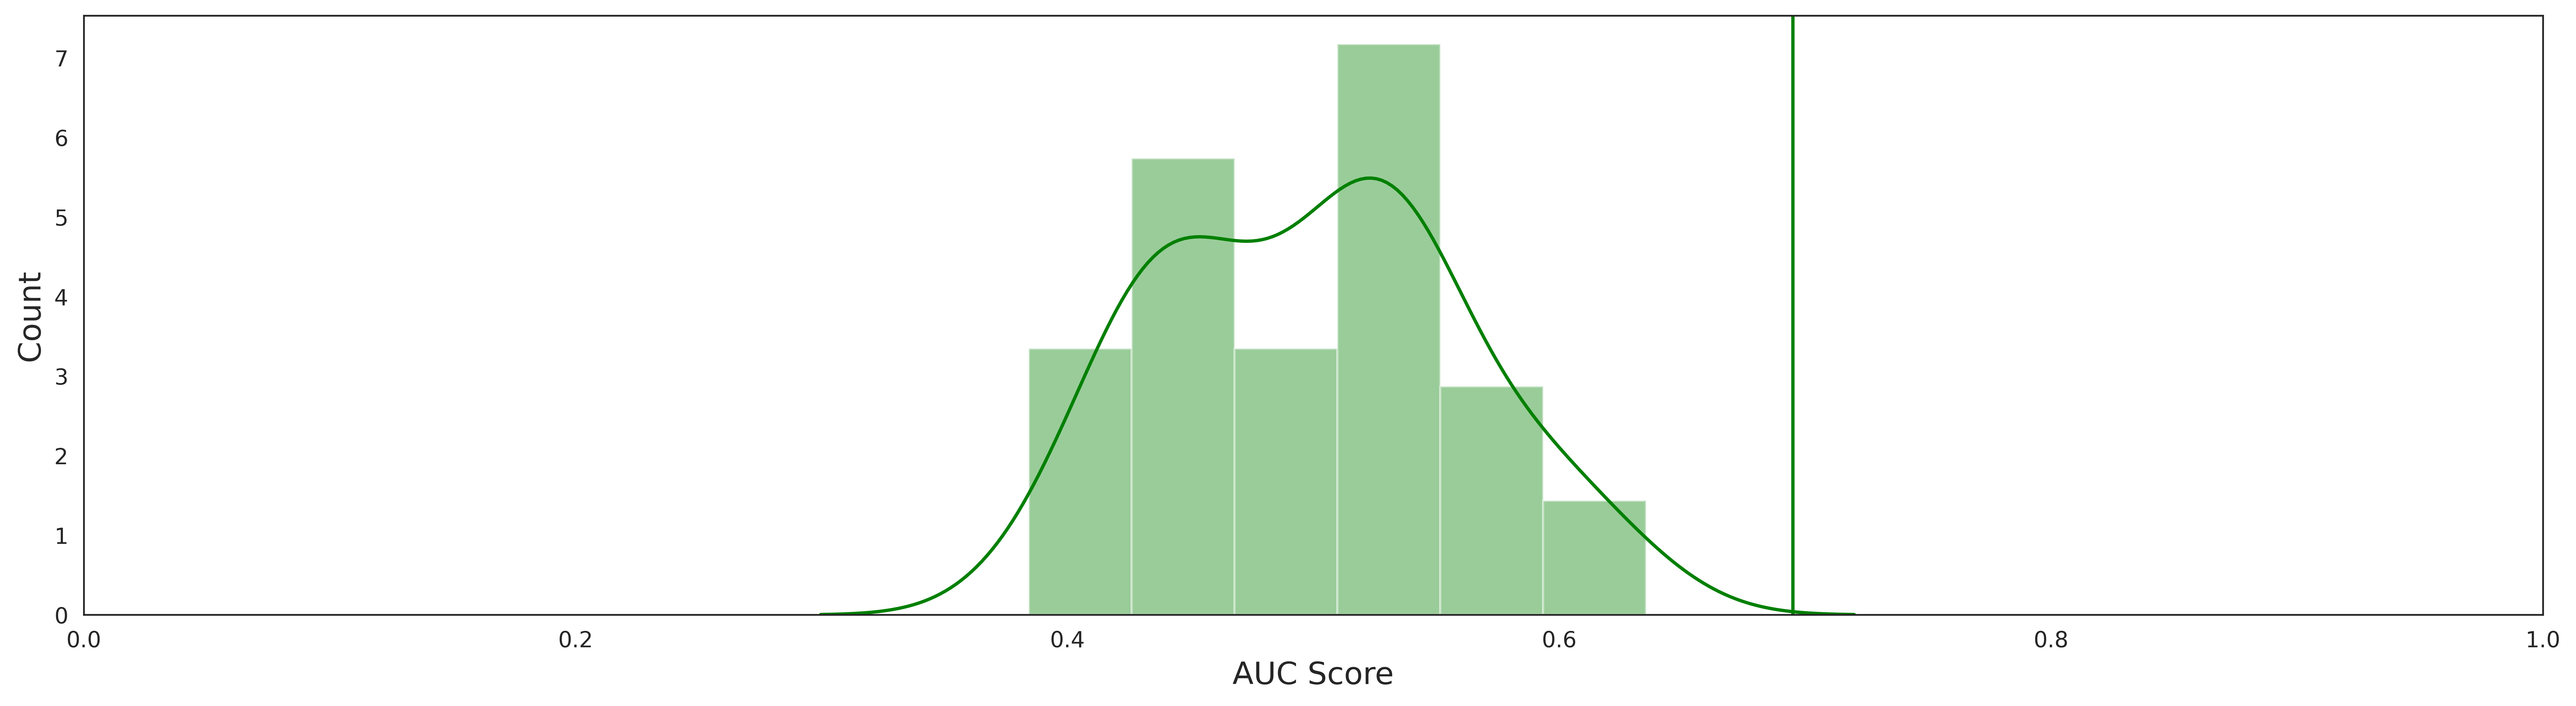

In [32]:
r_auc_score2 = roc_auc_score(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=600) 
ax = sns.distplot(accuracy_list, color="green")
plt.axvline(r_auc_score, color="green")
plt.xlabel("AUC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CatBoost_scrambling_plot.png', dpi=600, bbox_inches='tight')

In [34]:
mcc_list = []
for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    rf.fit(x_train, y_train)
    scrmb_predictions = rf.predict(X_v_test_data)
    print(i)
    mcc_v = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
    mcc_list.append(mcc_v)
mcc_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


[0.08344789259680933,
 -0.12762545547609766,
 -0.09815352015923445,
 0.13059341310768563,
 -0.10371498391270366,
 -0.09574072929139874,
 -0.10479875562772559,
 0.09676198270179992,
 -0.019012339363256654,
 -0.07483808850975934,
 0.08344789259680933,
 -0.10649483731501388,
 0.005526018623508129,
 -0.0592019631245657,
 -0.25026752597763674,
 0.032545631312798605,
 -0.12375515889028646,
 -0.0439901294395455,
 0.11879192382285876,
 0.25218525956108695,
 -0.12461673640397732,
 -0.1271609742609779,
 0.12659481786238197,
 -0.18940776734522968,
 0.07221185670623194,
 0.13837046277685847,
 0.1579227518764404,
 0.15411294806813858,
 0.04232524226593973,
 -0.14022299546217692,
 0.020253976437467288,
 0.25938614175149993,
 -0.011169607242065236,
 0.09578361570228418,
 0.004908949709013524,
 -0.11258771098604842,
 0.1305335380765732,
 0.010549086320500915,
 0.052206479785377506,
 -0.023206937150976263,
 -0.062468544179151896,
 -0.0439901294395455,
 -0.006866112664894734,
 0.018123807623841057,
 0.0

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

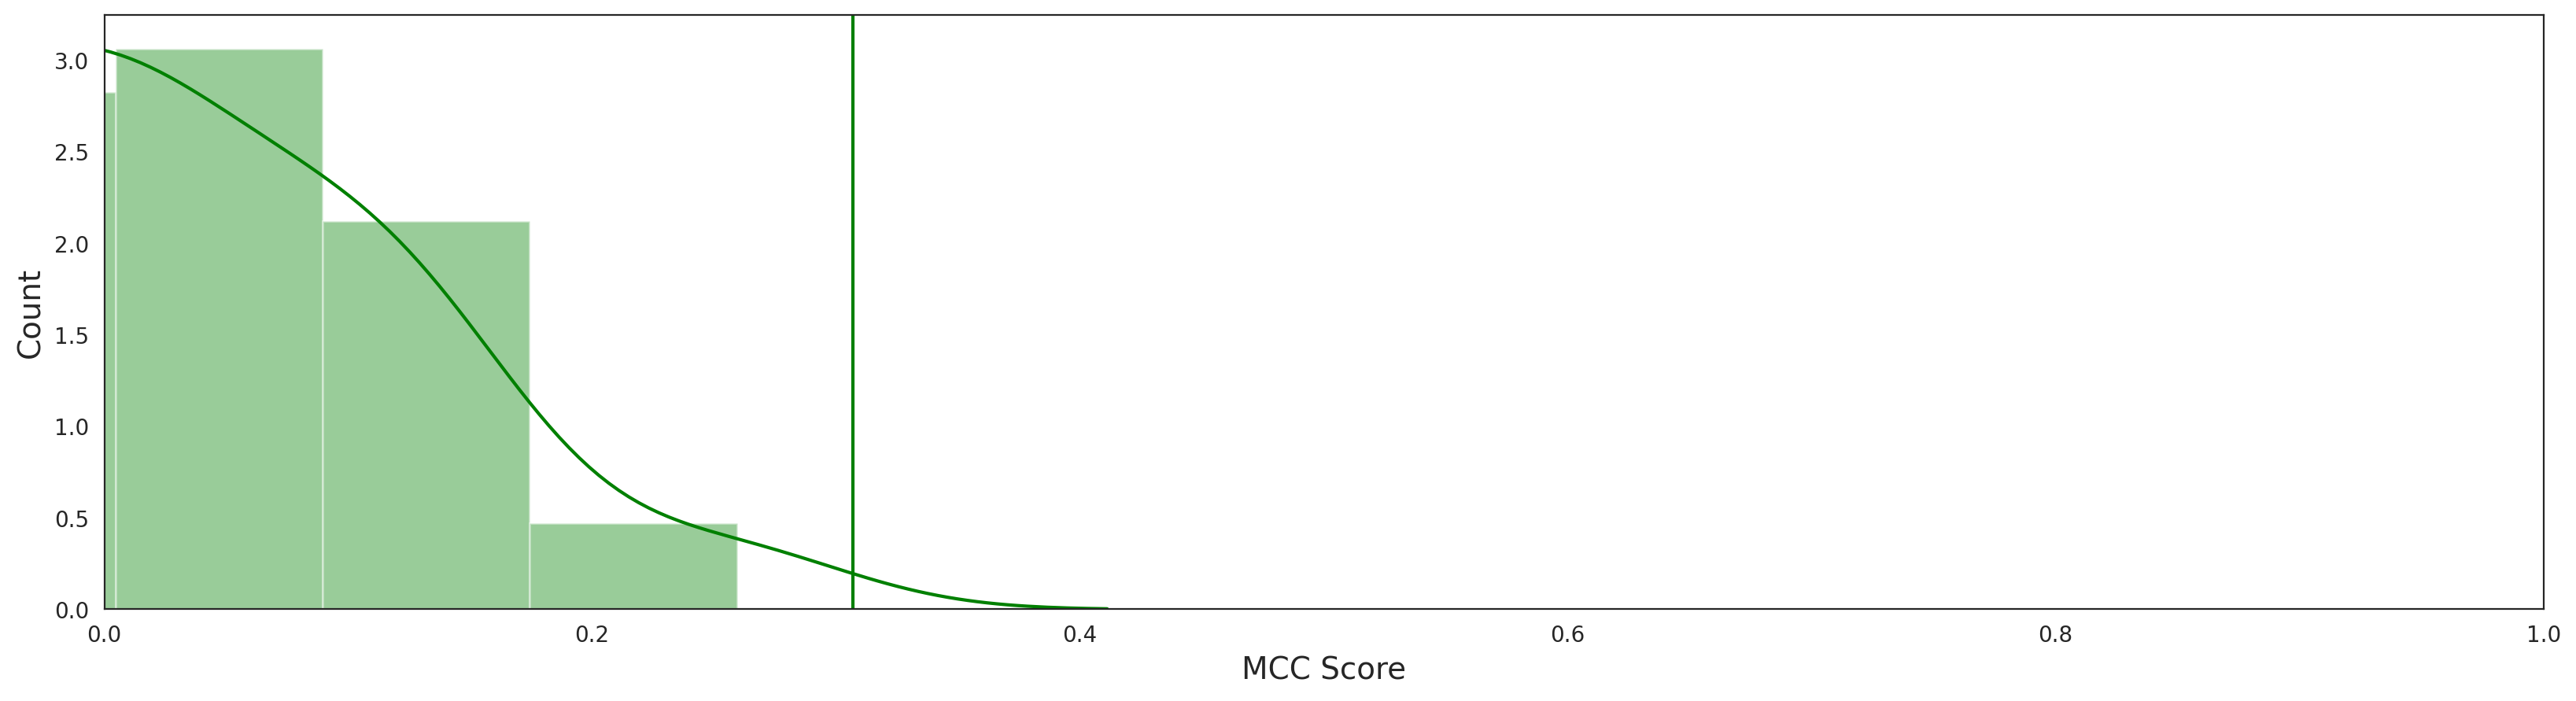

In [35]:
mcc2 = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(mcc_list, color="green")
plt.axvline(mcc, color="green")
plt.xlabel("MCC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CB_MCC_plot.png', dpi=600, bbox_inches='tight')

In [3]:
accuracy_list = [0.5394076985632963,
 0.5751897533206831,
 0.6175454052588778,
 0.46226958525345624,
 0.4313330170777989,
 0.4439380590946056,
 0.5116732176741665,
 0.5367138791000271,
 0.5867952019517485,
 0.459575765790187,
 0.42899498509081047,
 0.5111649498509081,
 0.42277717538628357,
 0.42093046896177827,
 0.5404072919490377,
 0.5891332339387367,
 0.49435822716183253,
 0.5054554079696394,
 0.4504947140146381,
 0.46579357549471395,
 0.5640925725128761,
 0.5508267823258335,
 0.4414306044998645,
 0.4313499593385741,
 0.5533511791813499,
 0.4587286527514231,
 0.6353517213336948,
 0.5224146110056925,
 0.5331898888587693,
 0.4970520466251016,
 0.4120188397939822,
 0.527802249932231,
 0.4720113851992409,
 0.6067870696665764,
 0.49554418541610196,
 0.48309162374627274,
 0.5923353212252644,
 0.5269720791542423,
 0.5061330984006506,
 0.46445513689346707,
 0.4220994849552725,
 0.3965674979669287,
 0.5368833017077799,
 0.5358667660612633,
 0.5109955272431554,
 0.5301572241799946,
 0.38430130116562755,
 0.425792897804283,
 0.4471401463811331,
 0.5419151531580374]
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(accuracy_list)
  
# Printing average of the list
print("Average of the accuracy list =", round(average, 3))

Average of the accuracy list = 0.5


In [2]:
mcc_list =[0.08344789259680933,
 -0.12762545547609766,
 -0.09815352015923445,
 0.13059341310768563,
 -0.10371498391270366,
 -0.09574072929139874,
 -0.10479875562772559,
 0.09676198270179992,
 -0.019012339363256654,
 -0.07483808850975934,
 0.08344789259680933,
 -0.10649483731501388,
 0.005526018623508129,
 -0.0592019631245657,
 -0.25026752597763674,
 0.032545631312798605,
 -0.12375515889028646,
 -0.0439901294395455,
 0.11879192382285876,
 0.25218525956108695,
 -0.12461673640397732,
 -0.1271609742609779,
 0.12659481786238197,
 -0.18940776734522968,
 0.07221185670623194,
 0.13837046277685847,
 0.1579227518764404,
 0.15411294806813858,
 0.04232524226593973,
 -0.14022299546217692,
 0.020253976437467288,
 0.25938614175149993,
 -0.011169607242065236,
 0.09578361570228418,
 0.004908949709013524,
 -0.11258771098604842,
 0.1305335380765732,
 0.010549086320500915,
 0.052206479785377506,
 -0.023206937150976263,
 -0.062468544179151896,
 -0.0439901294395455,
 -0.006866112664894734,
 0.018123807623841057,
 0.014334933798580217,
 -0.06356051129834785,
 -0.04059099381860814,
 0.0683847856411767,
 -0.13406170585894814,
 -0.0020736912375677835]
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(mcc_list)
  
# Printing average of the list
print("Average of the mcc list =", round(average, 3))

Average of the mcc list = -0.002


In [ ]:
external_data = pd.read_csv("IND_07-09-2022_morgan_chiral_1024FP.csv")
data_for_screening = pd.DataFrame(external_data)

In [ ]:
test_prob = rf.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('RF1024_probability_FP.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
estimator=RandomForestClassifier(random_state=42) 
param_grid = { 'bootstrap': [True, False],     
              'n_estimators': [200,400,500,800,1000],     
              'max_features': ['auto', 'sqrt', 'log2'],     
              'max_depth' : [5, 10, 20, 25, 30, None],     
              'min_samples_leaf': [1, 3, 4, 7],     
              'min_samples_split': [2, 3, 6, 10],     
              'criterion' :['gini', 'entropy'] } 
scoring = {'AUC':'roc_auc'}  
grid_mac_RF_stomek = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, refit='AUC', n_jobs=-1, cv=3, verbose=True)

In [ ]:
grid_mac_RF_stomek.fit(x_train.T,y_train.T)

In [ ]:
grid_mac_RF_stomek.best_params_